In [1]:
import re

from transformers import DonutProcessor, VisionEncoderDecoderModel
from datasets import load_dataset
import torch

In [2]:
from datasets import load_dataset

dataset = load_dataset("nielsr/docvqa_1200_examples_donut")


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/200 [00:00<?, ? examples/s]

In U.S. clinical trials, how many patients have received ACTOS?
{'match_score': 1.0, 'matched_text': 'over 4700 patients', 'start': 483, 'text': 'over 4700 patients'}
<PIL.JpegImagePlugin.JpegImageFile image mode=L size=1701x2201 at 0x7E23F689B1F0>


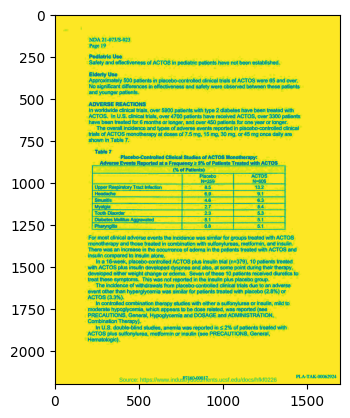

In [5]:
import matplotlib.pyplot as plt
import numpy as np  # Add this import

# print a row of train dataset
print(dataset["train"][500]['query']['en'])
print(dataset["train"][500]['answer'])
print(dataset['train'][500]['image'])
plt.imshow(dataset["train"][500]['image'])
plt.show()

image = dataset['train'][500]['image']
question = dataset["train"][500]['query']['en']

if len(image.shape) == 2:
    image = np.expand_dims(image, axis=0)  # Add channel dimension

In [6]:
processor = DonutProcessor.from_pretrained("amanm10000/donutFineTune")
model = VisionEncoderDecoderModel.from_pretrained("amanm10000/donutFineTune")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

preprocessor_config.json:   0%|          | 0.00/421 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.84k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/809M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/186 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           

In [7]:
# prepare decoder inputs
task_prompt = "<s_docvqa><s_question>{user_input}</s_question><s_answer>"
prompt = task_prompt.replace("{user_input}", question)
decoder_input_ids = processor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt").input_ids

In [8]:
pixel_values = processor(image, return_tensors="pt").pixel_values

outputs = model.generate(
    pixel_values.to(device),
    decoder_input_ids=decoder_input_ids.to(device),
    max_length=model.decoder.config.max_position_embeddings,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    use_cache=True,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
)

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(processor.token2json(sequence))

ValueError: Unsupported number of image dimensions: 2